In [1]:
from utils import *
%matplotlib inline

# Create a neural network

<center><img src="support/neuralnetwork.gif" width=500></center>

Now let's look how to create neural networks in Gluon. In addition the NDArray package (`nd`) that we just covered, we now will also import the neural network `nn` package from `gluon`.

In [2]:
import mxnet as mx

from mxnet import nd
from mxnet.gluon import nn

## Create your first neural network layer

Let's start with a dense layer with 2 output units.
The None is because there hasn't been any data passed in yet

<center><img src="support/fullyconnected.png" width=400></center>

In [3]:
layer = nn.Dense(2, activation="relu")
layer

Dense(None -> 2, Activation(relu))

Then initialize its weights with the default initialization method, which draws random values uniformly from $[-0.7, 0.7]$.

Initialization

In [4]:
layer.params

dense0_ (
  Parameter dense0_weight (shape=(2, 0), dtype=float32)
  Parameter dense0_bias (shape=(2,), dtype=float32)
)

In [5]:
layer.initialize(mx.init.Xavier())

Then we do a forward pass with random data. We create a $(3,4)$ shape random input `x` and feed into the layer to compute the output.

Get model prediction for input `x`

In [6]:
N = 3
x = nd.random.uniform(low=-1, high=1, shape=(N, 4))
x


[[ 0.09762704  0.18568921  0.43037868  0.6885315 ]
 [ 0.20552671  0.71589124  0.08976638  0.6945034 ]
 [-0.15269041  0.24712741  0.29178822 -0.23123658]]
<NDArray 3x4 @cpu(0)>

In [7]:
output = layer(x)
output


[[-0.       -0.      ]
 [-0.       -0.      ]
 [ 0.352628 -0.      ]]
<NDArray 3x2 @cpu(0)>

Inferred shape

In [8]:
layer.params

dense0_ (
  Parameter dense0_weight (shape=(2, 4), dtype=float32)
  Parameter dense0_bias (shape=(2,), dtype=float32)
)

As can be seen, the layer's input limit of 2 produced a $(3,2)$ shape output from our $(3,4)$ input. Note that we didn't specify the input size of `layer` before (though we can specify it with the argument `in_units=4` here), the system will automatically infer it during the first time we feed in data, create and initialize the weights. So we can access the weight after the first forward pass:

Weights

In [9]:
layer.weight.data()


[[-0.1248256  -0.40493077  0.783546   -0.88657403]
 [ 0.9273255  -0.45468742 -0.23311698 -0.04466975]]
<NDArray 2x4 @cpu(0)>

## Chain layers into a neural network

Let's first consider a simple case that a neural network is a chain of layers. During the forward pass, we run layers sequentially one-by-one.

In [10]:
net = nn.Sequential()
with net.name_scope():
    # Add a sequence of layers.
    net.add(
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )
net

Sequential(
  (0): Dense(None -> 120, Activation(relu))
  (1): Dense(None -> 84, Activation(relu))
  (2): Dense(None -> 10, linear)
)

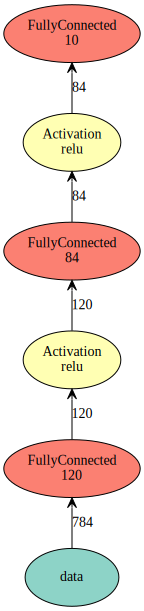

In [11]:
mx.viz.plot_network(net(mx.sym.var('data')), 
                    shape={"data":(10, 784)},
                    node_attrs={"shape":"oval","fixedsize":"False"},
                   )

<!--Mention the tuple option for kernel and stride as an exercise for the reader? Or leave it out as too much info for now?-->

The usage of `nn.Sequential` is similar to `nn.Dense`. In fact, both of them are subclasses of `nn.Block`. The following codes show how to initialize the weights and run the forward pass.

Run network

In [12]:
net.initialize()
x = nd.random.uniform(shape=(10, 784))
y = net(x)
y.shape

(10, 10)

We can use `[]` to index a particular layer. For example, the following
accesses the 1st layer's.

Specific layer

In [13]:
net

Sequential(
  (0): Dense(784 -> 120, Activation(relu))
  (1): Dense(120 -> 84, Activation(relu))
  (2): Dense(84 -> 10, linear)
)

In [14]:
"First layer weight shape {}".format(net[0].weight.data().shape)

'First layer weight shape (120, 784)'

## Create a neural network flexibly

In `nn.Sequential`, MXNet will automatically construct the forward function that sequentially executes added layers.
Now let's introduce another way to construct a network with a flexible forward function.

To do it, we create a subclass of `nn.Block` and implement two methods:

- `__init__` create the layers
- `forward` define the forward function.

In [15]:
class MixMLP(nn.Block):
    def __init__(self, **kwargs):
        # Run `nn.Block`'s init method
        super(MixMLP, self).__init__(**kwargs)
        with self.name_scope():
            self.features_1 = nn.Sequential()
            # Already within a name scope, no need to create
            # another scope.
            self.features_1.add(
                nn.Dense(3, activation='relu'),
                nn.Dense(4,activation='relu')
            )
            self.features_2 = nn.Sequential()
            # Already within a name scope, no need to create
            # another scope.
            self.features_2.add(
                nn.Dense(3, activation='relu'),
                nn.Dense(4,activation='relu')
            )
            self.output = nn.Dense(5)
    def forward(self, x1, x2):
        y1 = self.features_1(x1)
        y2 = self.features_2(x2)
        y = nd.add(y1, y2)
        print("Features", y)
        return self.output(y)

net2 = MixMLP()
net2

MixMLP(
  (features): Sequential(
    (0): Dense(None -> 3, Activation(relu))
    (1): Dense(None -> 4, linear)
  )
  (output): Dense(None -> 5, linear)
)

In the sequential chaining approach, we can only add instances with `nn.Block` as the base class and then run them in a forward pass. In this example, we used `print` to get the intermediate results and `nd.relu` to apply relu activation. So this approach provides a more flexible way to define the forward function.

The usage of `net` is similar as before.

Print statements

In [16]:
net2.initialize()

In [17]:
x = nd.random.uniform(shape=(2,2))
out = net2(x)

Features 
[[0.00118194 0.         0.         0.        ]
 [0.00062806 0.00011892 0.         0.00033978]]
<NDArray 2x4 @cpu(0)>


Finally, let's access a particular layer's weight

Weight access

In [18]:
net2.features[1].weight.data()


[[ 0.04872115  0.05109067  0.04302466]
 [-0.01240446  0.0096741  -0.05040384]
 [-0.01299434 -0.06534886 -0.06031662]
 [ 0.06756049  0.02764003 -0.0177393 ]]
<NDArray 4x3 @cpu(0)>

# Fast, portable neural networks with `hybrid`
<br>
<center><img src="support/fast.gif" width=300><center>

First let's understand imperative and symbolic programming

## Imperative Pseudofunction
```
def our_function(A, B, C, D):
    # Compute some intermediate values
    E = basic_function1(A, B)
    F = basic_function2(C, D)
    
    # Produce the thing you really care about
    G = basic_function3(E, F)
    return G
    
# Load up some data
W = some_stuff()
X = some_stuff()
Y = some_stuff()
Z = some_stuff()
    
result = our_function(W, X, Y, Z)
```

## Symbolic Pseudofunction

```
# Placeholders to stand in for real data
A = placeholder() 
B = placeholder()
C = placeholder()
D = placeholder()

# Compute some intermediate values
E = symbolic_function1(A, B)
F = symbolic_function2(C, D)
    
# Produce the thing you really care about
G = symbolic_function3(E, F)
    
our_function = library.compile(inputs=[A, B, C, D], outputs=[G])   
    
# Load up some data
W = some_stuff()
X = some_stuff()
Y = some_stuff()
Z = some_stuff()
    
result = our_function(W, X, Y, Z)
```

## Tradeoffs 

### Imperative Programs Tend to be More Flexible
* familiar style faster debugging, means you get to try out more ideas.
* the catch is that imperative programs are *comparatively* slow

### Symbolic Programs Tend to be More Efficient
* memory efficiency via reuse for intermediate results/speed optimizations via operator folding
* the catch is the tricky indirection of working with placeholders

## Getting the best of both worlds with MXNet Gluon's `HybridBlock`s


**All of MXNet's predefined layers are HybridBlocks.** This means that any network consisting entirely of predefined MXNet layers can be compiled and run at much faster speeds by calling ``.hybridize()``.

## HybridSequential

In [19]:
def get_net():
    # construct a MLP
    net = nn.HybridSequential()
    with net.name_scope():
        net.add(nn.Dense(256, activation="relu"))
        net.add(nn.Dense(128, activation="relu"))
        net.add(nn.Dense(2))
    # initialize the parameters
    net.collect_params().initialize()
    return net

# forward
x = nd.random_normal(shape=(1, 512))
net = get_net()
print('=== net(x) ==={}'.format(net(x)))

=== net(x) ===
[[0.03884146 0.20679656]]
<NDArray 1x2 @cpu(0)>


In [20]:
net.hybridize()
print('=== net(x) ==={}'.format(net(x)))

=== net(x) ===
[[0.03884146 0.20679656]]
<NDArray 1x2 @cpu(0)>


### Performance
Compare the performance before and after hybridizing 
by measuring the time it takes to make 1000 forward passes through the network.

In [21]:
from time import time
def bench(net, x):
    mx.nd.waitall()
    start = time()
    for i in range(1000):
        y = net(x)
    mx.nd.waitall()
    return time() - start

In [22]:
net = get_net()
print('Before hybridizing: %.4f sec'%(bench(net, x)))
net.hybridize()
print('After hybridizing: %.4f sec'%(bench(net, x)))

Before hybridizing: 0.6154 sec
After hybridizing: 0.2194 sec


## let's dive deeper into how `hybridize` works.
* Recall, Gluon networks are composed of Blocks each of which subclass `gluon.Block`
* For hybrid networks, we have `gluon.HybridBlock`
* To define a `HybridBlock`, we have to define a`hybrid_forward` function:

## HybridBlock

In [23]:
from mxnet import gluon

class Net(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            self.fc1 = nn.Dense(256)
            self.fc2 = nn.Dense(128)
            self.fc3 = nn.Dense(2)

    def hybrid_forward(self, F, x):
        # F is a function space that depends on the type of x
        # If x's type is NDArray, then F will be mxnet.nd
        # If x's type is Symbol, then F will be mxnet.sym
        print('type(x): {}, F: {}'.format(
                type(x).__name__, F.__name__))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [24]:
net = Net()
net.collect_params().initialize()
x = nd.random_normal(shape=(1, 512))
print('=== 1st forward ===')
y = net(x)
print('=== 2nd forward ===')
y = net(x)

=== 1st forward ===
type(x): NDArray, F: mxnet.ndarray
=== 2nd forward ===
type(x): NDArray, F: mxnet.ndarray


In [25]:
net.hybridize()
print('=== 1st forward ===')
y = net(x)
print('=== 2nd forward ===')
y = net(x)

=== 1st forward ===
type(x): Symbol, F: mxnet.symbol
=== 2nd forward ===
